<a href="https://www.kaggle.com/code/abigiyaayele/walmart-sales-prediction?scriptVersionId=188252037" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import seaborn as sn
from sklearn.preprocessing import StandardScaler
import re
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsRegressor
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
train = pd.read_csv('/kaggle/input/walmart-sales-prediction-pune-march-2023/train.csv')
train

,Year,Month,ProductCategory,Sales(In ThousandDollars)
0,2009,1,WomenClothing,1755.0
1,2009,1,MenClothing,524.0
2,2009,1,OtherClothing,936.0
3,2009,2,WomenClothing,1729.0
4,2009,2,MenClothing,496.0
...,...,...,...,...
175,2013,11,MenClothing,798.0
176,2013,11,OtherClothing,1209.0
177,2013,12,WomenClothing,4865.0
178,2013,12,MenClothing,1085.0


In [3]:
women_clothing_df = train[train['ProductCategory']=='WomenClothing']
men_clothing_df = train[train['ProductCategory']=='MenClothing']
other_clothing_df = train[train['ProductCategory']=='OtherClothing']

# DATA PREPROCESSING

## Macro economic data

In [4]:
me_df = pd.read_excel('/kaggle/input/walmart-sales-prediction-pune-march-2023/macro_economic.xlsx', 'Sheet1')
me_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 18 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   Year-Month                                                         96 non-null     object 
 1   Monthly Nominal GDP Index (inMillion$)                             96 non-null     float64
 2   Monthly Real GDP Index (inMillion$)                                96 non-null     float64
 3   CPI                                                                96 non-null     float64
 4   PartyInPower                                                       96 non-null     object 
 5   unemployment rate                                                  96 non-null     float64
 6   CommercialBankInterestRateonCreditCardPlans                        96 non-null     float64
 7   Finance Rate on Personal Loa

In [5]:
me_df.set_index('Year-Month', inplace=True)
me_df

,Monthly Nominal GDP Index (inMillion$),Monthly Real GDP Index (inMillion$),CPI,PartyInPower,unemployment rate,CommercialBankInterestRateonCreditCardPlans,"Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan",Earnings or wages in dollars per hour,AdvertisingExpenses (in Thousand Dollars),Cotton Monthly Price - US cents per Pound(lbs),Change(in%),Average upland planted(million acres),Average upland harvested(million acres),yieldperharvested acre,Production (in 480-lb netweright in million bales),Mill use (in 480-lb netweright in million bales),Exports
Year-Month,,,,,,,,,,,,,,,,,
2009 - Jan,14421.752895,14407.053343,233.402,Democrats,7.8,12.03,11.44,22.05,137,57.70,4.02,9.296,7.559,799,12.589,4.170,11.550
2009 - Feb,14389.200466,14366.176571,234.663,Democrats,8.3,12.97,11.05,22.22,200,55.21,-4.32,9.296,7.559,799,12.589,3.870,11.100
2009 - Mar,14340.701639,14351.786822,235.067,Democrats,8.7,12.97,11.05,22.22,?,51.50,-6.72,9.296,7.559,799,12.589,3.720,11.650
2009 - Apr,14326.815525,14351.601731,235.582,Democrats,9.0,12.97,11.05,22.13,214,56.78,10.25,9.296,7.559,787,12.400,3.620,12.225
2009 - May,14345.904809,14368.123959,235.975,Democrats,9.4,13.32,11.25,22.04,?,61.95,9.11,9.297,7.400,803,12.384,3.520,12.300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016 - Aug,18741.599947,16797.206610,264.160,Democrats,4.9,12.51,9.64,25.52,?,80.26,-0.99,9.824,9.340,787,15.314,3.575,10.950
2016 - Sep,18840.309646,16852.562745,264.602,Democrats,4.9,12.51,9.64,25.74,?,77.86,-2.99,9.950,9.464,790,15.580,3.475,10.950
2016 - Oct,18740.780023,16725.460098,264.738,Democrats,4.8,12.51,9.64,26.04,?,78.52,0.85,9.950,9.464,785,15.472,3.475,11.425


In [6]:
me_df.describe()

,Monthly Nominal GDP Index (inMillion$),Monthly Real GDP Index (inMillion$),CPI,unemployment rate,CommercialBankInterestRateonCreditCardPlans,"Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan",Earnings or wages in dollars per hour,Cotton Monthly Price - US cents per Pound(lbs),Change(in%),Average upland planted(million acres),Average upland harvested(million acres),yieldperharvested acre,Production (in 480-lb netweright in million bales),Mill use (in 480-lb netweright in million bales),Exports
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,16490.078125,15548.932194,252.372552,7.442708,12.519479,10.447604,23.793229,91.034479,0.615521,10.647698,8.851885,791.843750,14.616010,3.556104,11.061615
std,1427.554038,773.076316,9.290857,1.766397,0.722375,0.560651,1.147167,33.613974,6.919387,1.728418,1.102847,25.753621,2.007579,0.158263,1.710573
min,14317.372922,14345.676097,233.402000,4.600000,11.820000,9.450000,21.960000,51.500000,-23.590000,8.398000,7.345000,747.000000,11.751000,3.275000,8.500000
25%,15210.701514,14919.668252,242.474500,5.675000,11.950000,10.030000,22.797500,70.377500,-2.400000,9.296000,7.586000,772.750000,12.551000,3.410000,9.742500
50%,16422.454368,15442.996869,254.680500,7.750000,12.220000,10.470000,23.800000,83.905000,0.350000,10.260500,9.156500,790.000000,14.959000,3.572500,10.637500
75%,17772.032416,16262.237629,260.381500,9.000000,13.057500,10.940000,24.772500,93.322500,3.482500,11.412250,9.654500,807.000000,16.250000,3.675000,11.493750
max,19015.393408,16918.050624,265.421000,10.000000,14.260000,11.440000,26.040000,229.670000,22.850000,14.431000,10.577000,869.000000,18.375000,4.170000,15.280000


In [7]:
print(me_df.columns)

Index(['Monthly Nominal GDP Index (inMillion$)',
       'Monthly Real GDP Index (inMillion$)', 'CPI', 'PartyInPower',
       'unemployment rate', 'CommercialBankInterestRateonCreditCardPlans',
       'Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan',
       'Earnings or wages  in dollars per hour',
       'AdvertisingExpenses (in Thousand Dollars)',
       'Cotton Monthly Price - US cents per Pound(lbs)', 'Change(in%)',
       'Average upland planted(million acres)',
       'Average upland harvested(million acres)', 'yieldperharvested acre',
       'Production (in  480-lb netweright in million bales)',
       'Mill use  (in  480-lb netweright in million bales)', 'Exports'],
      dtype='object')


In [8]:
# Print all column names
print("Column names:", me_df.columns)

# Strip whitespace from column names
me_df.columns = me_df.columns.str.strip()

# Check if 'PartyInPower' exists in the columns
if 'PartyInPower' in me_df.columns:
    print("Unique values in 'PartyInPower':", me_df['PartyInPower'].unique())
else:
    print("'PartyInPower' column not found. Available columns:", me_df.columns)

# Check for similar column names
similar_columns = [col for col in me_df.columns if 'party' in col.lower()]
print("Columns containing 'party':", similar_columns)

Column names: Index(['Monthly Nominal GDP Index (inMillion$)',
       'Monthly Real GDP Index (inMillion$)', 'CPI', 'PartyInPower',
       'unemployment rate', 'CommercialBankInterestRateonCreditCardPlans',
       'Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan',
       'Earnings or wages  in dollars per hour',
       'AdvertisingExpenses (in Thousand Dollars)',
       'Cotton Monthly Price - US cents per Pound(lbs)', 'Change(in%)',
       'Average upland planted(million acres)',
       'Average upland harvested(million acres)', 'yieldperharvested acre',
       'Production (in  480-lb netweright in million bales)',
       'Mill use  (in  480-lb netweright in million bales)', 'Exports'],
      dtype='object')
Unique values in 'PartyInPower': ['Democrats']
Columns containing 'party': ['PartyInPower']


In [9]:
me_df['PartyInPower'].unique()

array(['Democrats'], dtype=object)

In [10]:
me_df.drop(columns=['PartyInPower'], inplace=True)

In [11]:
me_df['AdvertisingExpenses (in Thousand Dollars)'].unique()

array([137, 200, '?', 214, 248, 116, 165, 150, 221, 208, 201, 183],
      dtype=object)

In [12]:
def convert_to_float(value):
    try:
        return float(value)
    except ValueError:
        return None
    
me_df['AdvertisingExpenses (in Thousand Dollars)'] = me_df['AdvertisingExpenses (in Thousand Dollars)'].apply(convert_to_float)
me_df['AdvertisingExpenses (in Thousand Dollars)'].fillna(me_df['AdvertisingExpenses (in Thousand Dollars)'].median(), inplace=True)
me_df['AdvertisingExpenses (in Thousand Dollars)'].unique()

array([137., 200., 214., 248., 116., 165., 150., 221., 208., 201., 183.])

In [13]:
scaler = StandardScaler()
me_df = pd.DataFrame(scaler.fit_transform(me_df), columns=me_df.columns, index=me_df.index)
me_df = me_df.loc[:'2014 - Dec']
me_df

,Monthly Nominal GDP Index (inMillion$),Monthly Real GDP Index (inMillion$),CPI,unemployment rate,CommercialBankInterestRateonCreditCardPlans,"Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan",Earnings or wages in dollars per hour,AdvertisingExpenses (in Thousand Dollars),Cotton Monthly Price - US cents per Pound(lbs),Change(in%),Average upland planted(million acres),Average upland harvested(million acres),yieldperharvested acre,Production (in 480-lb netweright in million bales),Mill use (in 480-lb netweright in million bales),Exports
Year-Month,,,,,,,,,,,,,,,,
2009 - Jan,-1.456465,-1.484812,-2.052570,0.203333,-0.681154,1.779368,-1.527572,-4.508031,-0.996891,0.494603,-0.786149,-1.178470,0.279332,-1.014979,3.899323,0.287009
2009 - Feb,-1.479388,-1.537965,-1.916133,0.487881,0.626940,1.080097,-1.378603,0.120143,-1.071356,-0.717033,-0.786149,-1.178470,0.279332,-1.014979,1.993793,0.022558
2009 - Mar,-1.513539,-1.556676,-1.872421,0.715520,0.626940,1.080097,-1.378603,0.120143,-1.182306,-1.065705,-0.786149,-1.178470,0.279332,-1.014979,1.041028,0.345775
2009 - Apr,-1.523318,-1.556917,-1.816699,0.886249,0.626940,1.080097,-1.457469,1.148626,-1.024404,1.399698,-0.786149,-1.178470,-0.189068,-1.109617,0.405851,0.683684
2009 - May,-1.509876,-1.535433,-1.774177,1.113887,1.113996,1.438698,-1.536334,0.120143,-0.869792,1.234079,-0.785567,-1.323400,0.435465,-1.117628,-0.229325,0.727760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014 - Aug,0.841179,0.841944,0.941585,-0.707220,-0.973387,0.506336,0.461603,0.120143,-0.509428,-1.795012,0.315985,1.105759,0.630632,1.166689,1.390375,-0.535727
2014 - Sep,0.802955,0.759541,0.941477,-0.877949,-0.973387,0.506336,0.619335,0.120143,-0.527970,-0.211458,0.099048,0.765768,-0.071968,0.672972,1.390375,-0.947094
2014 - Oct,0.858643,0.842457,0.879371,-0.991769,-0.973387,0.506336,0.636861,0.120143,-0.618883,-0.690883,0.099048,0.765768,-0.618434,0.531266,1.390375,-0.947094


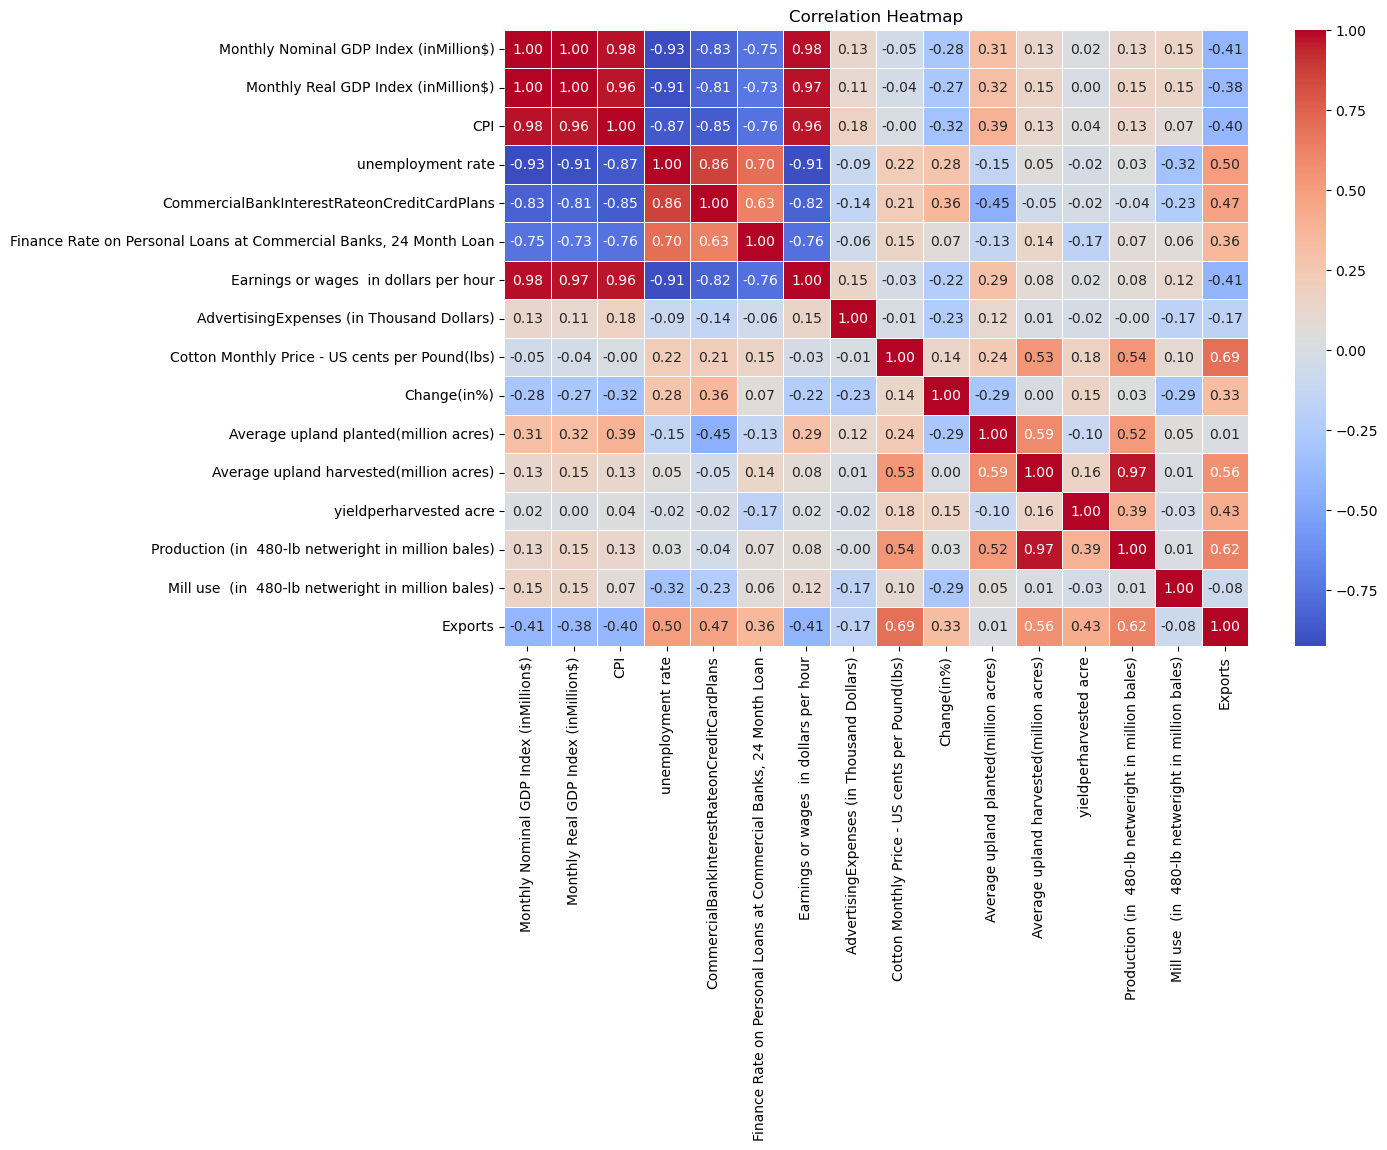

In [14]:
# Compute the correlation matrix
correlation_matrix = me_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sn.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

## Weather data

In [15]:
def load_sheet(year):
    path = '/kaggle/input/walmart-sales-prediction-pune-march-2023/WeatherData.xlsx'
    temp_df = pd.read_excel('/kaggle/input/walmart-sales-prediction-pune-march-2023/WeatherData.xlsx', year)
    temp_df['Year-Month'] = year + " - " + temp_df['Month']
    temp_df = temp_df.set_index('Year-Month').drop(columns=['Year', 'Month'])
    return temp_df

In [16]:
wth_df = load_sheet('2009')
for year in ('2010', '2011', '2012', '2013', '2014'):
    wth_df = pd.concat([wth_df, load_sheet(year)], axis=0)
wth_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2190 entries, 2009 - Jan to 2014 - Dec
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Day                          2190 non-null   int64 
 1   Temp high (°C)               2190 non-null   object
 2   Temp avg (°C)                2190 non-null   object
 3   Temp low (°C)                2190 non-null   object
 4   Dew Point high (°C)          2190 non-null   object
 5   Dew Point avg (°C)           2190 non-null   object
 6   Dew Point low (°C)           2190 non-null   object
 7   Humidity (%) high            2190 non-null   object
 8   Humidity (%) avg             2190 non-null   object
 9   Humidity (%) low             2190 non-null   object
 10  Sea Level Press. (hPa) high  2190 non-null   object
 11  Sea Level Press. (hPa) avg   2190 non-null   object
 12  Sea Level Press. (hPa) low   2190 non-null   object
 13  Visibility (km) high   

In [17]:
wth_df['Day'] = pd.to_datetime(wth_df['Day'])
wth_df['Day'] 

Year-Month
2009 - Jan   1970-01-01 00:00:00.000000001
2009 - Jan   1970-01-01 00:00:00.000000002
2009 - Jan   1970-01-01 00:00:00.000000003
2009 - Jan   1970-01-01 00:00:00.000000004
2009 - Jan   1970-01-01 00:00:00.000000005
                          ...             
2014 - Dec   1970-01-01 00:00:00.000000027
2014 - Dec   1970-01-01 00:00:00.000000028
2014 - Dec   1970-01-01 00:00:00.000000029
2014 - Dec   1970-01-01 00:00:00.000000030
2014 - Dec   1970-01-01 00:00:00.000000031
Name: Day, Length: 2190, dtype: datetime64[ns]

In [18]:
wth_df.drop(columns=['Day'], inplace=True)

In [19]:
def to_float(text):
    try: 
        value = float(text)
    except ValueError:
        pattern = r'- \d+'
        if re.match(pattern, text):
            value = float(text[1:]) * -1
        else:
            value = None
    return value

columns_to_convert = [column for column in wth_df.columns if column != 'WeatherEvent']
wth_df[columns_to_convert] = wth_df[columns_to_convert].applymap(to_float)

In [20]:
wth_df[columns_to_convert]

,Temp high (°C),Temp avg (°C),Temp low (°C),Dew Point high (°C),Dew Point avg (°C),Dew Point low (°C),Humidity (%) high,Humidity (%) avg,Humidity (%) low,Sea Level Press. (hPa) high,Sea Level Press. (hPa) avg,Sea Level Press. (hPa) low,Visibility (km) high,Visibility (km) avg,Visibility (km) low,Wind (km/h) low,Wind (km/h) avg,Wind (km/h) high,Precip. (mm) sum
Year-Month,,,,,,,,,,,,,,,,,,,
2009 - Jan,-3.0,-6.0,-9.0,-16.0,-17.0,-19.0,54.0,43.0,32.0,1025.0,1023.0,1015.0,16.0,16.0,16.0,37.0,18.0,60.0,0.00
2009 - Jan,1.0,-2.0,-5.0,-3.0,-7.0,-17.0,78.0,57.0,36.0,1022.0,1012.0,1007.0,16.0,13.0,2.0,27.0,10.0,48.0,NaN
2009 - Jan,3.0,1.0,-2.0,-5.0,-9.0,-13.0,72.0,54.0,35.0,1018.0,1015.0,1008.0,16.0,16.0,16.0,27.0,16.0,42.0,NaN
2009 - Jan,6.0,1.0,-4.0,-10.0,-12.0,-13.0,55.0,42.0,29.0,1020.0,1017.0,1015.0,16.0,16.0,16.0,32.0,12.0,40.0,0.00
2009 - Jan,6.0,5.0,3.0,-1.0,-5.0,-16.0,62.0,48.0,33.0,1016.0,1014.0,1013.0,16.0,16.0,16.0,23.0,11.0,34.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014 - Dec,10.0,7.0,4.0,-2.0,-2.0,-3.0,64.0,53.0,42.0,1024.0,1023.0,1020.0,16.0,16.0,16.0,21.0,9.0,29.0,0.00
2014 - Dec,13.0,10.0,7.0,2.0,-1.0,-2.0,53.0,47.0,41.0,1025.0,1022.0,1018.0,16.0,16.0,16.0,23.0,7.0,40.0,0.00
2014 - Dec,12.0,9.0,6.0,6.0,3.0,-3.0,92.0,73.0,53.0,1018.0,1014.0,1012.0,16.0,14.0,3.0,24.0,9.0,35.0,2.54


In [21]:
imputer = IterativeImputer(
    estimator=KNeighborsRegressor(),
    max_iter=10,
    random_state=12
)
wth_df[columns_to_convert] = imputer.fit_transform(wth_df[columns_to_convert])

In [22]:
wth_df = pd.get_dummies(wth_df, columns=['WeatherEvent'])

In [23]:
wth_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2190 entries, 2009 - Jan to 2014 - Dec
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Temp high (°C)                  2190 non-null   float64
 1   Temp avg (°C)                   2190 non-null   float64
 2   Temp low (°C)                   2190 non-null   float64
 3   Dew Point high (°C)             2190 non-null   float64
 4   Dew Point avg (°C)              2190 non-null   float64
 5   Dew Point low (°C)              2190 non-null   float64
 6   Humidity (%) high               2190 non-null   float64
 7   Humidity (%) avg                2190 non-null   float64
 8   Humidity (%) low                2190 non-null   float64
 9   Sea Level Press. (hPa) high     2190 non-null   float64
 10  Sea Level Press. (hPa) avg      2190 non-null   float64
 11  Sea Level Press. (hPa) low      2190 non-null   float64
 12  Visibility (km) high    

In [24]:
wth_df = wth_df.groupby(wth_df.index).agg({
    'Temp high (°C)': 'max',
    'Temp avg (°C)': 'mean',
    'Temp low (°C)': 'min',
    'Dew Point high (°C)': 'max',
    'Dew Point avg (°C)': 'mean',
    'Dew Point low (°C)': 'min',
    'Humidity\xa0(%) high': 'max',
    'Humidity\xa0(%) avg': 'mean',
    'Humidity\xa0(%) low': 'min',
    'Sea Level Press.\xa0(hPa) high': 'max',
    'Sea Level Press.\xa0(hPa) avg': 'mean',
    'Sea Level Press.\xa0(hPa) low': 'min',
    'Visibility\xa0(km) high': 'max',
    'Visibility\xa0(km) avg': 'mean',
    'Visibility\xa0(km) low': 'min',
    'Wind\xa0(km/h) low': 'min',
    'Wind\xa0(km/h) avg': 'mean',
    'Wind\xa0(km/h) high': 'max',
    'Precip.\xa0(mm) sum': 'sum',
    'WeatherEvent_Fog': 'sum',
    'WeatherEvent_Fog , Rain': 'sum',
    'WeatherEvent_Fog , Rain , Snow': 'sum',
    'WeatherEvent_Fog , Snow': 'sum',
    'WeatherEvent_Rain': 'sum',
    'WeatherEvent_Rain , Snow': 'sum',
    'WeatherEvent_Snow': 'sum',
    'WeatherEvent_Thunderstorm': 'sum',
})
wth_df

,Temp high (°C),Temp avg (°C),Temp low (°C),Dew Point high (°C),Dew Point avg (°C),Dew Point low (°C),Humidity (%) high,Humidity (%) avg,Humidity (%) low,Sea Level Press. (hPa) high,...,Wind (km/h) high,Precip. (mm) sum,WeatherEvent_Fog,"WeatherEvent_Fog , Rain","WeatherEvent_Fog , Rain , Snow","WeatherEvent_Fog , Snow",WeatherEvent_Rain,"WeatherEvent_Rain , Snow",WeatherEvent_Snow,WeatherEvent_Thunderstorm
Year-Month,,,,,,,,,,,,,,,,,,,,,
2009 - Apr,33.0,12.733333,1.0,14.0,2.533333,-12.0,100.0,55.700000,16.0,1033.0,...,61.0,119.424,0,1,0,0,11,0,0,0
2009 - Aug,33.0,24.387097,17.0,25.0,18.483871,8.0,100.0,72.483871,35.0,1025.0,...,64.0,111.048,0,5,0,0,8,0,0,0
2009 - Dec,19.0,2.354839,-9.0,16.0,-4.677419,-21.0,100.0,61.741935,23.0,1034.0,...,64.0,184.650,0,0,0,3,6,2,0,0
2009 - Feb,18.0,2.785714,-11.0,11.0,-6.392857,-19.0,100.0,54.000000,20.0,1032.0,...,77.0,21.952,0,0,0,1,4,1,0,0
2009 - Jan,8.0,-2.096774,-14.0,4.0,-9.903226,-22.0,100.0,57.354839,22.0,1036.0,...,60.0,78.086,0,0,2,2,3,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014 - Mar,19.0,2.806452,-13.0,10.0,-8.258065,-25.0,100.0,47.322581,19.0,1037.0,...,61.0,89.160,0,0,0,0,6,0,2,0
2014 - May,30.0,17.612903,5.0,18.0,8.096774,-7.0,97.0,59.967742,18.0,1030.0,...,55.0,235.970,0,3,0,0,9,0,0,0
2014 - Nov,21.0,7.533333,-6.0,16.0,-1.766667,-17.0,93.0,54.866667,17.0,1033.0,...,58.0,115.830,1,1,0,0,6,1,1,0


In [25]:
scaler = StandardScaler()
wth_df = pd.DataFrame(scaler.fit_transform(wth_df), columns=wth_df.columns, index=wth_df.index)
wth_df

,Temp high (°C),Temp avg (°C),Temp low (°C),Dew Point high (°C),Dew Point avg (°C),Dew Point low (°C),Humidity (%) high,Humidity (%) avg,Humidity (%) low,Sea Level Press. (hPa) high,...,Wind (km/h) high,Precip. (mm) sum,WeatherEvent_Fog,"WeatherEvent_Fog , Rain","WeatherEvent_Fog , Rain , Snow","WeatherEvent_Fog , Snow",WeatherEvent_Rain,"WeatherEvent_Rain , Snow",WeatherEvent_Snow,WeatherEvent_Thunderstorm
Year-Month,,,,,,,,,,,,,,,,,,,,,
2009 - Apr,0.884439,-0.066004,-0.164120,-0.633104,-0.319977,-0.385267,0.423678,-1.101324,-1.283803,0.433336,...,-0.010382,0.081156,-0.408248,-0.448322,-0.353553,-0.439057,1.194824,-0.477396,-0.471405,-0.118678
2009 - Aug,0.884439,1.269856,1.479933,1.348786,1.457125,1.482692,0.423678,1.603283,1.802739,-1.136485,...,0.176500,-0.035682,-0.408248,1.942728,-0.353553,-0.439057,0.235411,-0.477396,-0.471405,-0.118678
2009 - Dec,-0.860208,-1.255681,-1.191653,-0.272760,-1.123351,-1.225848,0.423678,-0.127707,-0.146656,0.629563,...,0.176500,0.990999,-0.408248,-1.046085,-0.353553,2.524578,-0.404197,2.796177,-0.471405,-0.118678
2009 - Feb,-0.984826,-1.206290,-1.397159,-1.173619,-1.314474,-1.039052,0.423678,-1.375268,-0.634005,0.237108,...,0.986325,-1.278490,-0.408248,-1.046085,-0.353553,0.548821,-1.043805,1.159390,-0.471405,-0.118678
2009 - Jan,-2.231002,-1.765965,-1.705419,-2.434822,-1.705575,-1.319246,0.423678,-0.834658,-0.309105,1.022018,...,-0.072677,-0.495472,-0.408248,-1.046085,2.828427,1.536700,-1.363610,-0.477396,1.649916,-0.118678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014 - Mar,-0.860208,-1.203913,-1.602666,-1.353791,-1.522283,-1.599440,0.423678,-2.451289,-0.796454,1.218246,...,-0.010382,-0.340999,-0.408248,-1.046085,-0.353553,-0.439057,-0.404197,-0.477396,0.942809,-0.118678
2014 - May,0.510586,0.493337,0.246893,0.087584,0.299864,0.081723,-0.922123,-0.413606,-0.958904,-0.155347,...,-0.384147,1.706866,-0.408248,0.747203,-0.353553,-0.439057,0.555216,-0.477396,-0.471405,-0.118678
2014 - Nov,-0.610973,-0.662075,-0.883393,-0.272760,-0.799054,-0.852256,-2.716524,-1.235610,-1.121353,0.433336,...,-0.197265,0.031023,2.041241,-0.448322,-0.353553,-0.439057,-0.404197,1.159390,0.235702,-0.118678


## Events Data

In [26]:
ev_df = pd.read_excel('/kaggle/input/walmart-sales-prediction-pune-march-2023/Events_HolidaysData.xlsx', 'Sheet1')
ev_df

,Year,MonthDate,Event,DayCategory
0,2009,2001-01-01,New Year's Day,Federal Holiday
1,2009,2019-01-01,Martin Luther King Jr. Day,Federal Holiday
2,2009,2014-02-01,Valentine's Day,Event
3,2009,2016-02-01,Presidents' Day,Federal Holiday
4,2009,2012-04-01,Easter Sunday,Event
...,...,...,...,...
145,2016,2024-11-01,Thanksgiving Day,Federal Holiday
146,2016,2024-12-01,Christmas Eve,Event
147,2016,2025-12-01,Christmas Day,Federal Holiday
148,2016,2026-12-01,'Christmas Day' observed,Federal Holiday


In [27]:
ev_df = ev_df[ev_df['Year'] < 2015]
ev_df

,Year,MonthDate,Event,DayCategory
0,2009,2001-01-01,New Year's Day,Federal Holiday
1,2009,2019-01-01,Martin Luther King Jr. Day,Federal Holiday
2,2009,2014-02-01,Valentine's Day,Event
3,2009,2016-02-01,Presidents' Day,Federal Holiday
4,2009,2012-04-01,Easter Sunday,Event
...,...,...,...,...
105,2014,2011-11-01,Veterans Day,Federal Holiday
106,2014,2027-11-01,Thanksgiving Day,Federal Holiday
107,2014,2024-12-01,Christmas Eve,Event
108,2014,2025-12-01,Christmas Day,Federal Holiday


In [28]:
def yearmonth(row):
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    return str(row['Year']) + ' - ' + months[int(row['MonthDate'].month) - 1] 


ev_df['Year-Month'] =  ev_df.apply(yearmonth, axis=1)
ev_df.drop(columns=['Year', 'MonthDate', 'Event'], inplace=True)
ev_df.set_index('Year-Month', inplace=True)
ev_df

/tmp/ipykernel_20/1340755218.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ev_df['Year-Month'] =  ev_df.apply(yearmonth, axis=1)
/tmp/ipykernel_20/1340755218.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ev_df.drop(columns=['Year', 'MonthDate', 'Event'], inplace=True)


,DayCategory
Year-Month,
2009 - Jan,Federal Holiday
2009 - Jan,Federal Holiday
2009 - Feb,Event
2009 - Feb,Federal Holiday
2009 - Apr,Event
...,...
2014 - Nov,Federal Holiday
2014 - Nov,Federal Holiday
2014 - Dec,Event


In [29]:
ev_df = pd.get_dummies(ev_df, columns=['DayCategory'])
ev_df

,DayCategory_Event,DayCategory_Federal Holiday
Year-Month,,
2009 - Jan,0,1
2009 - Jan,0,1
2009 - Feb,1,0
2009 - Feb,0,1
2009 - Apr,1,0
...,...,...
2014 - Nov,0,1
2014 - Nov,0,1
2014 - Dec,1,0


In [30]:
ev_df = ev_df.groupby(ev_df.index).agg({
    'DayCategory_Event': 'sum',
    'DayCategory_Federal Holiday': 'sum'
})

## JOIN DATASETS

In [31]:
tempdf = wth_df.merge(me_df, left_index=True, right_index=True)

In [32]:
df = pd.merge(tempdf, ev_df, on='Year-Month', how='left')

In [33]:
df[['DayCategory_Event', 'DayCategory_Federal Holiday']] = df[['DayCategory_Event', 'DayCategory_Federal Holiday']].fillna(0)

In [34]:
scaler = StandardScaler()
df[['DayCategory_Event', 'DayCategory_Federal Holiday']] = scaler.fit_transform(df[['DayCategory_Event', 'DayCategory_Federal Holiday']])
df

,Temp high (°C),Temp avg (°C),Temp low (°C),Dew Point high (°C),Dew Point avg (°C),Dew Point low (°C),Humidity (%) high,Humidity (%) avg,Humidity (%) low,Sea Level Press. (hPa) high,...,Cotton Monthly Price - US cents per Pound(lbs),Change(in%),Average upland planted(million acres),Average upland harvested(million acres),yieldperharvested acre,Production (in 480-lb netweright in million bales),Mill use (in 480-lb netweright in million bales),Exports,DayCategory_Event,DayCategory_Federal Holiday
Year-Month,,,,,,,,,,,,,,,,,,,,,
2009 - Apr,0.884439,-0.066004,-0.164120,-0.633104,-0.319977,-0.385267,0.423678,-1.101324,-1.283803,0.433336,...,-1.024404,1.399698,-0.786149,-1.178470,-0.189068,-1.109617,0.405851,0.683684,0.591608,-1.153113
2009 - Aug,0.884439,1.269856,1.479933,1.348786,1.457125,1.482692,0.423678,1.603283,1.802739,-1.136485,...,-0.800710,-0.210005,-1.013555,-1.123780,0.669665,-0.889297,-0.546914,-0.800177,-0.929670,-1.153113
2009 - Dec,-0.860208,-1.255681,-1.191653,-0.272760,-1.123351,-1.225848,0.423678,-0.127707,-0.146656,0.629563,...,-0.426290,0.923180,-0.964700,-1.153860,-0.696501,-1.197244,-1.182090,-0.374118,2.112886,0.104828
2009 - Feb,-0.984826,-1.206290,-1.397159,-1.173619,-1.314474,-1.039052,0.423678,-1.375268,-0.634005,0.237108,...,-1.071356,-0.717033,-0.786149,-1.178470,0.279332,-1.014979,1.993793,0.022558,0.591608,0.104828
2009 - Jan,-2.231002,-1.765965,-1.705419,-2.434822,-1.705575,-1.319246,0.423678,-0.834658,-0.309105,1.022018,...,-0.996891,0.494603,-0.786149,-1.178470,0.279332,-1.014979,3.899323,0.287009,-0.929670,1.362770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014 - Mar,-0.860208,-1.203913,-1.602666,-1.353791,-1.522283,-1.599440,0.423678,-2.451289,-0.796454,1.218246,...,0.176908,0.358040,-0.256892,-1.264152,0.591599,-1.034007,0.151781,-0.653260,-0.929670,-1.153113
2014 - May,0.510586,0.493337,0.246893,0.087584,0.299864,0.081723,-0.922123,-0.413606,-0.958904,-0.155347,...,0.050108,-0.318966,-0.256892,-1.373532,0.396432,-1.172208,0.151781,-0.814869,0.591608,0.104828
2014 - Nov,-0.610973,-0.662075,-0.883393,-0.272760,-0.799054,-0.852256,-2.716524,-1.235610,-1.121353,0.433336,...,-0.702918,-0.669091,0.099048,0.765768,-0.345201,0.602370,1.390375,-0.947094,-0.929670,1.362770


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72 entries, 2009 - Apr to 2014 - Sep
Data columns (total 45 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   Temp high (°C)                                                     72 non-null     float64
 1   Temp avg (°C)                                                      72 non-null     float64
 2   Temp low (°C)                                                      72 non-null     float64
 3   Dew Point high (°C)                                                72 non-null     float64
 4   Dew Point avg (°C)                                                 72 non-null     float64
 5   Dew Point low (°C)                                                 72 non-null     float64
 6   Humidity (%) high                                                  72 non-null     float64
 7   Humidity (%) avg

In [36]:
train

,Year,Month,ProductCategory,Sales(In ThousandDollars)
0,2009,1,WomenClothing,1755.0
1,2009,1,MenClothing,524.0
2,2009,1,OtherClothing,936.0
3,2009,2,WomenClothing,1729.0
4,2009,2,MenClothing,496.0
...,...,...,...,...
175,2013,11,MenClothing,798.0
176,2013,11,OtherClothing,1209.0
177,2013,12,WomenClothing,4865.0
178,2013,12,MenClothing,1085.0


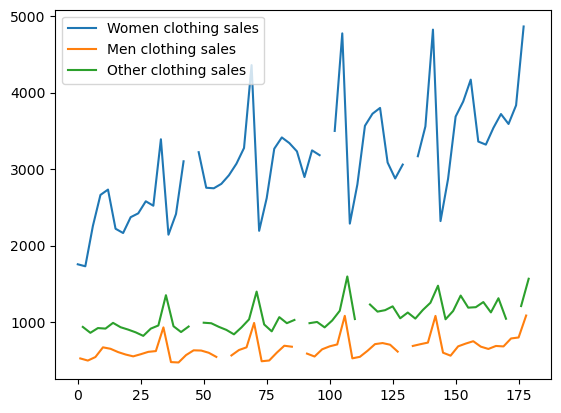

In [37]:
ax = women_clothing_df.plot(y='Sales(In ThousandDollars)', label='Women clothing sales')
men_clothing_df.plot(y='Sales(In ThousandDollars)', ax=ax, label='Men clothing sales')
other_clothing_df.plot(y='Sales(In ThousandDollars)', ax=ax, label='Other clothing sales')
plt.show()

In [38]:
def totext(value):
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    return months[value - 1]

train['Year-Month'] = train['Year'].astype(str) + ' - ' + train['Month'].apply(totext)
train.drop(columns=['Year', 'Month'], inplace=True)
train.set_index('Year-Month', inplace=True)
train

,ProductCategory,Sales(In ThousandDollars)
Year-Month,,
2009 - Jan,WomenClothing,1755.0
2009 - Jan,MenClothing,524.0
2009 - Jan,OtherClothing,936.0
2009 - Feb,WomenClothing,1729.0
2009 - Feb,MenClothing,496.0
...,...,...
2013 - Nov,MenClothing,798.0
2013 - Nov,OtherClothing,1209.0
2013 - Dec,WomenClothing,4865.0


In [39]:
women_clothing = train[train['ProductCategory'] == 'WomenClothing']['Sales(In ThousandDollars)']
men_clothing = train[train['ProductCategory'] == 'MenClothing']['Sales(In ThousandDollars)']
other_clothing = train[train['ProductCategory'] == 'OtherClothing']['Sales(In ThousandDollars)']

train_target = pd.DataFrame({
    'WomenClothing Sales': women_clothing,
    'MenClothing Sales': men_clothing,
    'OtherClothing Sales': other_clothing,
    },
    index=train.index.unique()
)

train_target['WomenClothing Sales'].fillna(train_target['WomenClothing Sales'].mean(), inplace=True)
train_target['MenClothing Sales'].fillna(train_target['MenClothing Sales'].mean(), inplace=True)
train_target['OtherClothing Sales'].fillna(train_target['OtherClothing Sales'].mean(), inplace=True)

In [40]:
train_data = df.loc[:'2013 - Sep']
test_data = df.loc['2014 - Apr':]
test_data

,Temp high (°C),Temp avg (°C),Temp low (°C),Dew Point high (°C),Dew Point avg (°C),Dew Point low (°C),Humidity (%) high,Humidity (%) avg,Humidity (%) low,Sea Level Press. (hPa) high,...,Cotton Monthly Price - US cents per Pound(lbs),Change(in%),Average upland planted(million acres),Average upland harvested(million acres),yieldperharvested acre,Production (in 480-lb netweright in million bales),Mill use (in 480-lb netweright in million bales),Exports,DayCategory_Event,DayCategory_Federal Holiday
Year-Month,,,,,,,,,,,,,,,,,,,,,
2014 - Apr,-0.112502,-0.211201,-0.369626,-0.633104,-0.539090,-0.478664,-2.716524,-1.450468,-1.933601,2.003156,...,0.094667,-0.502018,-0.256892,-1.264152,-0.189068,-1.192738,0.151781,-0.638569,2.112886,-1.153113
2014 - Aug,0.759822,1.181111,1.377179,0.628099,1.007878,1.389294,-2.716524,-0.351228,0.503143,-1.136485,...,-0.509428,-1.795012,0.315985,1.105759,0.630632,1.166689,1.390375,-0.535727,-0.929670,-1.153113
2014 - Dec,-0.984826,-0.926584,-0.677886,-0.272760,-0.738795,-0.945654,0.423678,0.350525,0.503143,1.610701,...,-0.679890,0.076196,0.099048,0.765768,-1.242967,0.365025,1.390375,-0.947094,2.112886,0.104828
2014 - Feb,-1.607914,-1.492862,-1.397159,-1.894306,-1.473635,-1.786236,-1.370723,-0.615592,0.015794,0.825791,...,0.090181,0.404529,-0.256892,-1.264152,0.591599,-1.034007,0.151781,-0.770794,0.591608,0.104828
2014 - Jan,-1.483296,-1.728125,-1.910926,-0.813276,-1.649509,-1.786236,0.423678,-0.499723,0.015794,1.610701,...,-0.002227,0.487339,-0.256892,-1.264152,0.591599,-1.034007,0.151781,-0.770794,-0.929670,1.362770
2014 - Jul,0.884439,1.303135,1.479933,1.168614,1.230704,1.389294,0.423678,0.230967,0.990491,-1.332712,...,-0.215156,-1.218249,0.315985,-0.235064,0.474499,0.670469,1.390375,-0.788424,-0.929670,0.104828
2014 - Jun,0.759822,1.042077,1.068920,0.628099,0.942707,0.828907,0.423678,0.010564,-0.471555,-0.547802,...,-0.004022,-0.372719,0.171748,-0.235064,0.747732,-0.052081,0.755199,-1.082258,0.591608,-1.153113
2014 - Mar,-0.860208,-1.203913,-1.602666,-1.353791,-1.522283,-1.599440,0.423678,-2.451289,-0.796454,1.218246,...,0.176908,0.358040,-0.256892,-1.264152,0.591599,-1.034007,0.151781,-0.653260,-0.929670,-1.153113
2014 - May,0.510586,0.493337,0.246893,0.087584,0.299864,0.081723,-0.922123,-0.413606,-0.958904,-0.155347,...,0.050108,-0.318966,-0.256892,-1.373532,0.396432,-1.172208,0.151781,-0.814869,0.591608,0.104828


In [41]:
train_target = train_target.sort_index()

X_train, X_val, y_train, y_val = train_test_split(train_data, train_target, test_size=0.1, random_state=42)

In [42]:

model = keras.models.Sequential([
    keras.layers.Dense(100, input_dim=45, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(50, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(3, activation=None),
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [43]:
 early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10, 
    restore_best_weights=True
)

Epoch 1/100
27/27 [==============================] - 2s 12ms/step - loss: 3943223.7500 - val_loss: 3725382.2500
Epoch 2/100
27/27 [==============================] - 0s 3ms/step - loss: 3942686.5000 - val_loss: 3724672.7500
Epoch 3/100
27/27 [==============================] - 0s 3ms/step - loss: 3942147.5000 - val_loss: 3723979.0000
Epoch 4/100
27/27 [==============================] - 0s 3ms/step - loss: 3940990.5000 - val_loss: 3723196.7500
Epoch 5/100
27/27 [==============================] - 0s 3ms/step - loss: 3940862.2500 - val_loss: 3722435.2500
Epoch 6/100
27/27 [==============================] - 0s 3ms/step - loss: 3939737.7500 - val_loss: 3721601.7500
Epoch 7/100
27/27 [==============================] - 0s 3ms/step - loss: 3938522.0000 - val_loss: 3720376.0000
Epoch 8/100
27/27 [==============================] - 0s 3ms/step - loss: 3936803.7500 - val_loss: 3718850.0000
Epoch 9/100
27/27 [==============================] - 0s 3ms/step - loss: 3935306.7500 - val_loss: 3716258.0000


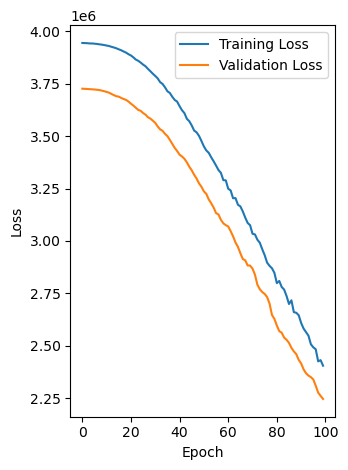

In [44]:
history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=2,
        callbacks=[early_stopping]
    )
    
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [45]:
predictions = model.predict(test_data)

1/1 [==============================] - 0s 142ms/step


In [46]:
predictions

array([[1373.645  , 1167.7517 , 1260.6698 ],
       [1030.6458 ,  869.2501 ,  936.48145],
       [1169.6066 ,  988.1709 , 1077.0781 ],
       [1059.952  ,  893.7658 ,  971.51965],
       [ 685.9588 ,  578.6383 ,  630.88934],
       [ 641.936  ,  530.4295 ,  581.01904],
       [ 924.32776,  771.0096 ,  841.52234],
       [ 875.4932 ,  744.2564 ,  806.6292 ],
       [1035.3169 ,  865.6722 ,  946.3191 ],
       [1179.7302 ,  996.15326, 1078.7462 ],
       [1037.479  ,  869.7532 ,  943.33765],
       [ 984.18524,  827.3726 ,  899.45044]], dtype=float32)

In [47]:
def month_text_to_num(text):
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    return months.index(text) + 1
    
year = [date[:4] for date in test_data.index]
months = []
for i in [month_text_to_num(date[7:]) for date in test_data.index]:
    months.extend([i] * 3)
months
year = [2014 for i in range(len(months))]

In [48]:
sales = []
for i in predictions:
    for j in i:
        sales.append(j)
product_category = []
for i in range(int(len(sales)/3)):
    product_category.extend(['WomenClothing', 'MenClothing', 'OtherClothing'])

submission = pd.DataFrame({
    'Month': months,
    'ProductCategory': product_category,
    'Sales(In ThousandDollars)': sales
})
submission.sort_values(by=['Month', 'ProductCategory'], ascending=[True, False], inplace=True)
submission.reset_index(drop=True, inplace=True)
submission = submission.drop(columns=['Month', 'ProductCategory'])
submission.index = range(1, len(submission) + 1)
submission = submission.rename_axis('Year')
submission.to_csv('submission.csv')